<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>, except for figures of external sources as indicated. It is partly based on the tutorial prepared by Marcus Voss and Nikola Milojevic-Dupont for participants of the WiDS Datathon 2022.

Example Code Walkthrough: Low Voltage Load Forecasting
==============

Author: [Marcus Voss](mailto:voss.marcus@gmail.com) – *Birds on Mars, TU Berlin, Climate Change AI*

Author: [Stephen Haben](mailto:stephen.haben@maths.ox.ac.uk) - *Mathematical Institute, University of Oxford*


# Summary 🎯

In this walkthrough, we demonstrate some of the techniques and methods for low voltage load forecasting as described in the Open Access book <a rel="license" href="https://www.springeropen.com/"> "Core Methods and Concepts in Load Forecasting" </a>. 

Topics covered will include:

- **Exploratory data analysis** using common Python plotting libraries <a rel="license" href="https://matplotlib.org/stable/index.html">matplotlib</a> and <a rel="license" href="https://seaborn.pydata.org/index.html">Seaborn</a>. What are some of the features and patterns in the data  and how can we identify them?
- **Feature modelling** using common Python data library <a rel="license" href="https://pandas.pydata.org/">Pandas</a>. It shows how to derive features from EDA and domain knowlege and calculating them manually. Note, that one can also use libraries like [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html) to support in generating more general time series features. 
- **Cross-validation** using machine learning library <a rel="license" href="https://scikit-learn.org/stable/">Scikit-learn</a>. How do we choose the model hyperparameters and check which models may generalise the best?
- **Model fitting and selection** (including simple benchmarks) in Python. It also shows how to manually utilise sklearn to apply machine learning to the time series forecasting problem. Libraries like [sktime](https://www.sktime.org/en/stable/), [tslearn](https://github.com/tslearn-team/tslearn/tree/main/tslearn) and [darts](https://unit8co.github.io/darts/#forecasting-models) can make this a bit easier with less lines of code.  
- **Model evaluation and diagnosis.** How do we calcuate the errors and identify areas of improvement? We discusses some time series specific model diagnostics. 

Some concepts demonstrated in this tutorial may also be helpful for other time series tasks beyond load forecasting. 

| 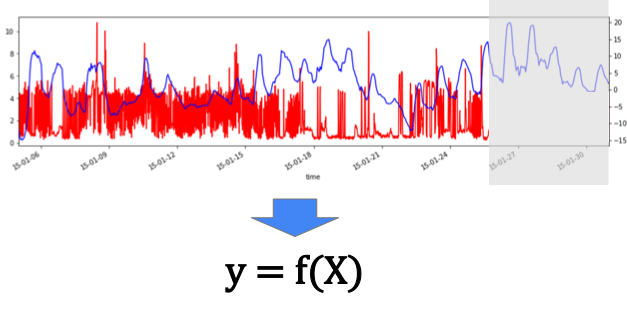 | 
|:--:| 
| *Source: Own figure* |





# Outline ⏰

1. [Time Series Forecasting](#tsforecasting)
1. [Time Series Data in Pandas](#pandas)
1. [Exploratory Data Analysis](#eda)

1. [Load Forecasting Features](#features)
    1. [Encoding Cyclic Calendar-based Features](#cyclic)
    1. [Features For our Example Data](#featurecandidates)

1. [Preparing the Data for Training and Testing](#inputoutput)

1. [Model Fitting](#modelfit)
    1. [Baseline/Benchmark Models](#benchmark)
    1. [Comparing Encodings for categorical variables](#encodings)
    1. [Fitting a neural network using Tensorflow](#ann)

1. [Model diagnostics](#diagnostics)

1. [Cross-validation for time series](#crossvalidation)

1. [Where to go from here?](#sota)
1. [References](#references)
1. [Selected Ressources on Time Series](#ressources)



# Time Series Forecasting <a name="tsforecasting"></a>

As described in <a href="https://www.springeropen.com/">Chapter 4</a>, supervised machine learning algorithms aim to learn the relationship (a function **f**) between a set of input variables referred to as features (or independent variables) that are typically measured or preset and have some influence on one or several output variables. These features are often denoted as a matrix $\mathbf{X}$. When the task is to predict a numeric variable, i.e., for regression problems, the output is referred to as target (or dependent variable) and often denoted as a vector $\mathbf{y}$. The relationship between the inputs and outputs are related via the following relationships including some error $\epsilon$

$$\mathbf{y} = f(\mathbf{X})+ \epsilon$$

Time series forecasting problems can be formulated as supervised learning problem (<a href="https://www.springeropen.com/">Chapter 5</a>) which makes them ammenable to a wealth of machine learning (<a href="https://www.springeropen.com/">Chapter 10</a>) and statistical (<a href="https://www.springeropen.com/">Chapter 9</a>) methods, some of which will be demonstrated in this tutorial. For load forecasting the output vector is the next few time steps in the forecast horizon, and the inputs can also include lagged values of the load. 

The next section loads some example load time series and this will be analysed to help identify useful features to include in the forecast models. 

# Loading Time Series Data into Pandas  <a name="pandas"></a>

We start by loading all the necessary packages which will be used for this task.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf

np.random.seed(42)
stock2 = pd.DataFrame()
stock2.loc[:, "random_number"] = np.random.choice([-1, 1], size=299, replace=True)
stock2.loc[:, "random_walk"] = stock2["random_number"].cumsum()
stock2.loc[:, "Close"] = stock2["random_walk"] + 120

DATA_URL = "https://gist.githubusercontent.com/marcus-voss/b5fcbc82adff8f227fe8e8ee126c5f87/raw/b4b7d89425d5e7a60bec95d347b7139476603216/load_data.csv"

ModuleNotFoundError: No module named 'statsmodels'

Time series data can be handled by pandas out-of-the-box. For, instance, one can read in data and create a DatatimeIndex by parsing a date column:

In [ ]:
DATA_URL = "https://gist.githubusercontent.com/marcus-voss/b5fcbc82adff8f227fe8e8ee126c5f87/raw/b4b7d89425d5e7a60bec95d347b7139476603216/load_data.csv"

data = pd.read_csv(DATA_URL, parse_dates=[0], index_col=0)
data.head()

Note the DatetimeIndex:

In [ ]:
data.index

For many time series tasks it is useful to have regular interval time series data. Pandas provides many useful functions to *aggregate* data points to lower resolution or *interpolate* data to a higher resolution (see [this overview here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)). For instance if you want to make the Load series a daily time series, you can aggregate the series using the mean:

In [1]:
data.load.resample("1D").mean().plot()

NameError: name 'data' is not defined

# Exploratory Data Analysis <a name="eda"></a>

Let's plot the target variable, the power load (kWh, in blue), together with a covariate, outside temperature (celsius, in orange).

In [ ]:
ax = data["2015-07-01":"2015-07-08"].load.plot(figsize=(12,3),label='load')
ax2 = ax.twinx()
data["2015-07-01":"2015-07-08"].temperature.plot(ax=ax2, color="C1",label='temperature')
handles, labels = ax.get_legend_handles_labels()
plt.legend()
ax.legend(handles=handles, labels=labels)
ax2.set_ylabel('temperature [celsius]')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('days');

We can see some correlation between the two series, but the regular pattern also may hint at autocorrelation (read more on autocorrelation see (<a href="https://www.springeropen.com/">Section 3.5</a>) and (<a href="https://www.springeropen.com/">Section 6.2</a>)). Let's further investigate these relationships:

In [ ]:
data = pd.read_csv(DATA_URL, parse_dates=[0], index_col=0)

fig, ax = plt.subplots(1,3, figsize=(20,5));
ax[0].scatter(data.temperature, data.load)
ax[0].set_xlabel("Temperature (C°)")
ax[0].set_ylabel("Load (kW)")

data["2015-04-01":"2015-04-15"].load.plot(ax=ax[1])

acf_fig = plot_acf(data.load, ax=ax[2], lags=8*24)

This basic EDA for load data shows that there is:
- a correlation with weather information that can be exploited,
- a seasonal component of daily and weekly pattern that should be modelled,
- autocorrelation at multiple lags that should be considered.

# Load Forecasting Features <a name="features"></a>



As discussed in (<a href="https://www.springeropen.com/">Chapter 6.2</a>) there are many different things one can *generally* do. Generally in time series forecasting there are the following options:
* Add "lagged", i.e. prior, values of your target **y** (or other variables) to model autoregressive effects (use autocorrelation plots to figure out which ones are important!), 
* Add date time features features (e.g. the day of the week, month of the year, if it is a holiday yes/no, the hour of day) to model seasonal effects, 
* Moving window statistics (e.g. averages) of variables,
* Interactions of two or more variables,
* Add features of "known" external correlated time series (here: weather forecast).

While these by itself can inform machine learning models, it may be usefuly to engineer them to more elaborate features, especially for statistical models, e.g.,
* Polynomials of variables to model non-linear effects (especially for simpler models like linear regression),
* Ratios of variables,
* Utilise basis functions (<a href="https://www.springeropen.com/">Chapter 6.2.5</a>)

In load forecasting the literature the most common features are (see [1] and <a href="https://www.springeropen.com/">Chapter 6.2.6</a>):
* weather-related variables (most importantly, temperature, humidity, solar irradiance)
* Daily, weekly and annual seasonality
* Lagged load
* Socioeconomic indicators (Number of residents, demographics, floor space, tariffs and other interventions, monthly energy consumption)

The following figure schematically shows how the feature matrix $X$ and the target vector $y$ could look for the problem of forecasting electric load:

| 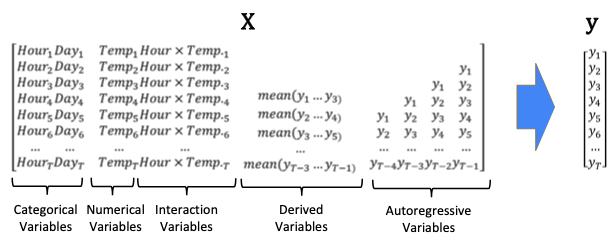 | 
|:--:| 
| *Source: Own figure.* |

(Note that creating lags leads to NaN values that need to be cut off before training models.)   

The above figure shows how one can forecast one specific point in the future (e.g., *one-step ahead* in the same resolution. Often one needs to forecast several steps ahead. This can generally be achieved using one of the following two approaches (<a href="https://www.springeropen.com/">Section 5.2</a>):
- a *recursive scheme*, that iteratively predicts one step at a time and uses the former iteration's forecast as input, 
- a *direct scheme*, that predicts several steps at once, either as direct output of one model or the output of several models.

The former has the advantage that it can model the dependencies between the steps in the forecast horizon. An disadvantage is that forecast errors can accumluate over the prediction horizon.


| 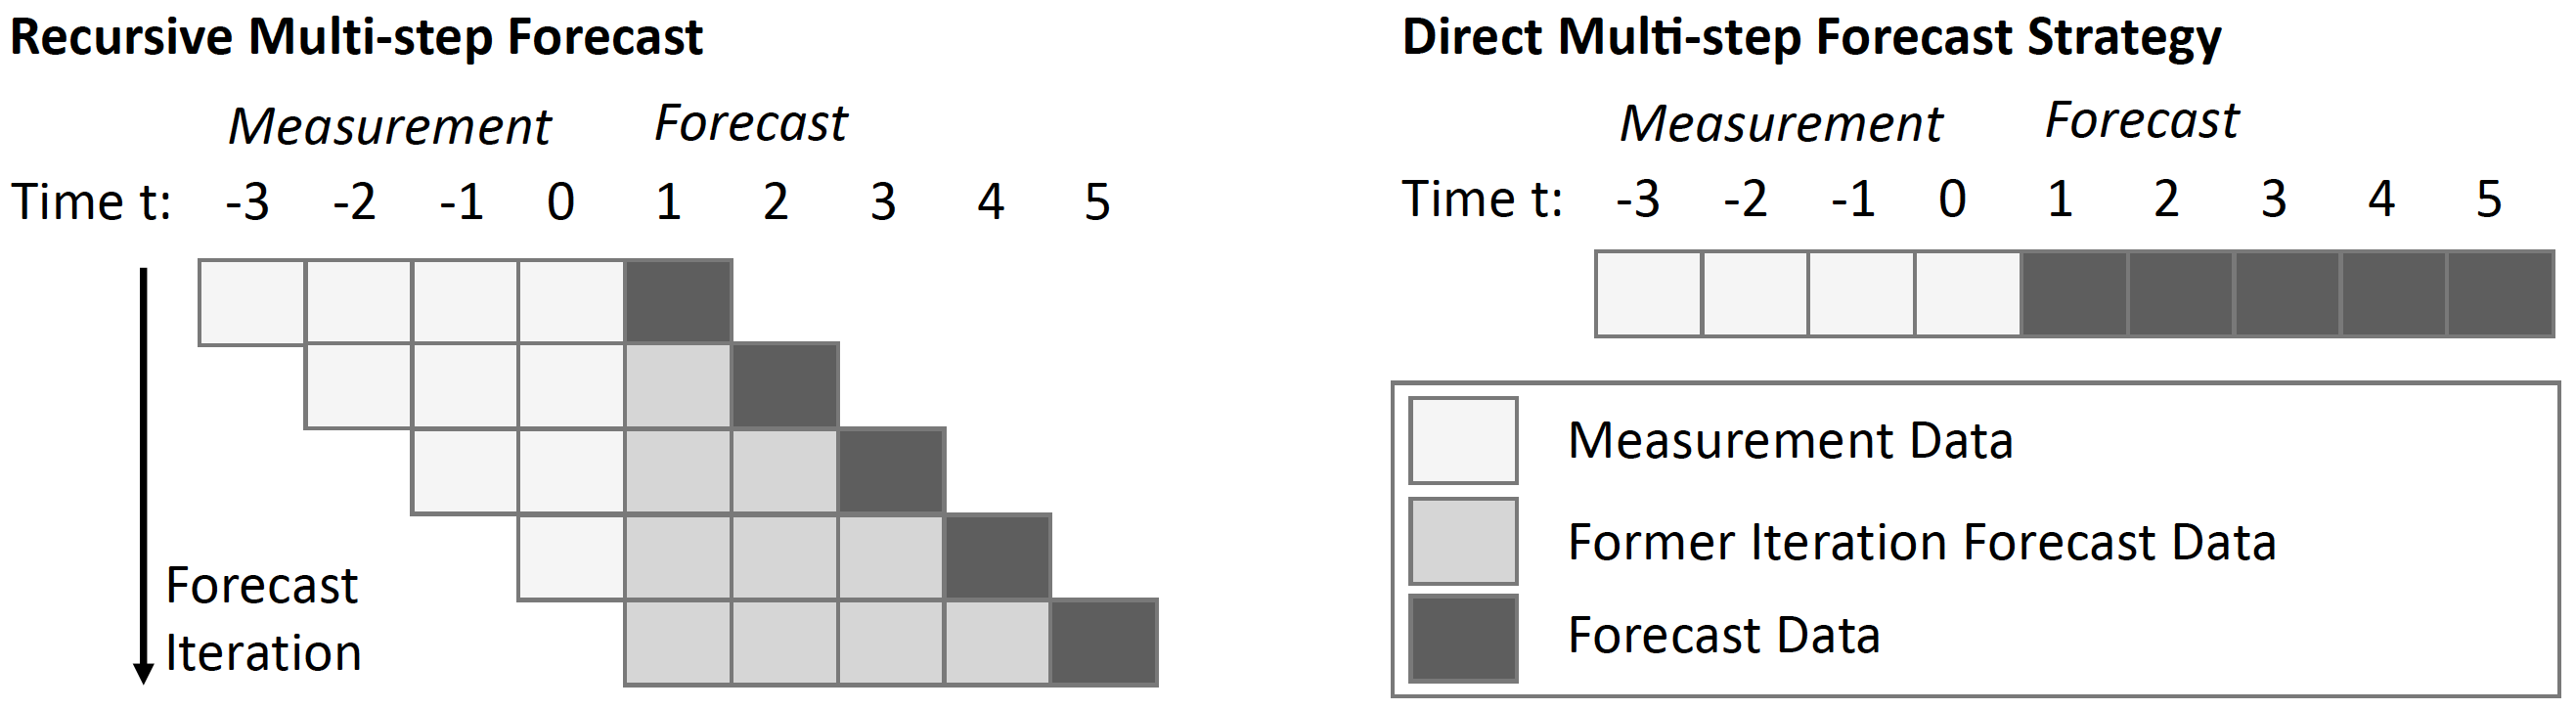 | 
|:--:| 
| *Source: Own figure.* |

## Encoding Cyclic Calendar-based Features <a name="cyclic"></a>

When encoding calendar-based variables, there are different ways to approach this:
* Encode them as numbers (e.g., January, February, … = 1, 2, ….). **Problem**: Numbers indicate "closeness", "order" and linear increasing relationship that may not be useful for all models.
* Dummy-encode/One-Hot-Encode (e.g. Monday, Tuesday, … = (1,0,0,0,0,0,0), (0,1,0,0,0,0,0), …) the variables. This is the most common approach. **Problem**: However, no information about order is preserved. For instance, January and February are somewhat similar. Also, cyclic properties are not preserved, e.g. December and January may also be considered similar.
* Model seasonal properties using Sine and Cosine functions!

As described in [this post,](https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2) (also see <a href="https://www.springeropen.com/">Section 14.2</a> of the book) one can encode the seasonal properties using Sine and Cosine functions as visualised in the following figure from the post:



| <img src="https://miro.medium.com/max/1400/1*GuL5Cq_yBBKY6aqUD0jtDQ.png" alt="Encoding" style="float: left; margin-right: 10px;" />| 
|:--:| 
| *Source: [Blog Post on Towards Datascience.](https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2)* |


## Features For our Example Data <a name="featurecandidates"></a>

In [ ]:
# add sine/cosine encoding for hour of day and month of the year
data["hour_x"] = np.sin(np.radians((360/24) * data.index.hour))
data["hour_y"] = np.cos(np.radians((360/24) * data.index.hour))
data["month_x"] = np.sin(np.radians((360/12) * data.index.month))
data["month_y"] = np.cos(np.radians((360/12) * data.index.month))

# temperature related variables, the mean of last day and lagged by one value, which may better capture the "recency effect"
data["temperature_rolling_mean"] = data.loc[:,"temperature"].rolling(window=24).mean()
data["temperature_lag_1"] = data.temperature.shift(1)

# Add lags up to one day
MAX_LAG = 24
for lag in range(1, MAX_LAG+1):
    data["load_lag_" + str(lag)] = data["load"].shift(lag)

# add calendar-based variables as categorical data
data["day_of_week"] = data.index.weekday
data["hour_of_day"] = data.index.hour
data["month_of_year"] = data.index.month
data["weekend"] = data.index.weekday.isin([5,6])
data = pd.get_dummies(data, columns=["day_of_week", "hour_of_day", "month_of_year"])
data.head()

In [ ]:
data.columns

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.scatter(data["hour_x"].iloc[:24], data["hour_y"].iloc[:24])
for h in range(24):
    ax.annotate(data.index.hour[h], (data["hour_x"].iloc[h], data["hour_y"].iloc[h]))

We have now created 76 features from our 3 initial columns that we are hoping will provide the model with richer predictive information!




# Cross-validation for time series  <a name="crossvalidation"></a>

When trying to compare different version of a model (e.g., trying different features or model hyper-parameters), it is best practice to use *cross validation*. Cross validation is a tool to try to analyze how well a model generalises to new unseen data. Forecast models must be tested on unseen data to ensure that the forecaster is not unrealistically tailoring (subconsciously or otherwise) the model to score higher than would be possible in practice. In real applications the future data is not available and forecasters would not have the advantages of knowing the actual values in advance. Further information on cross validation can be found in <a href="https://www.springeropen.com/">Chapter 8</a> of the book.

Tuning the parameters can generate substantial performance gain, but this can also lead to overfitting. Thus, we use a cross-validation scheme to understand the impact of several values for the  hyper-parameters by splitting the training set in several training and validation folds. Here, we are tuning the parameter *k* of *k*-nearest neighbor. 

We try 3 cross-validation approaches:
- *shuffled*, we take random samples for each fold
- *by blocks*, we take folds that are continuous time blocks all with the same duration     
- *by time series split*, we take folds that are continuous time blocks of different durations (for example fold 1 is two months, fold 2 is three months,...)

See below schematics of blocked (left), time series (middle) and shuffled (right) folds:


| 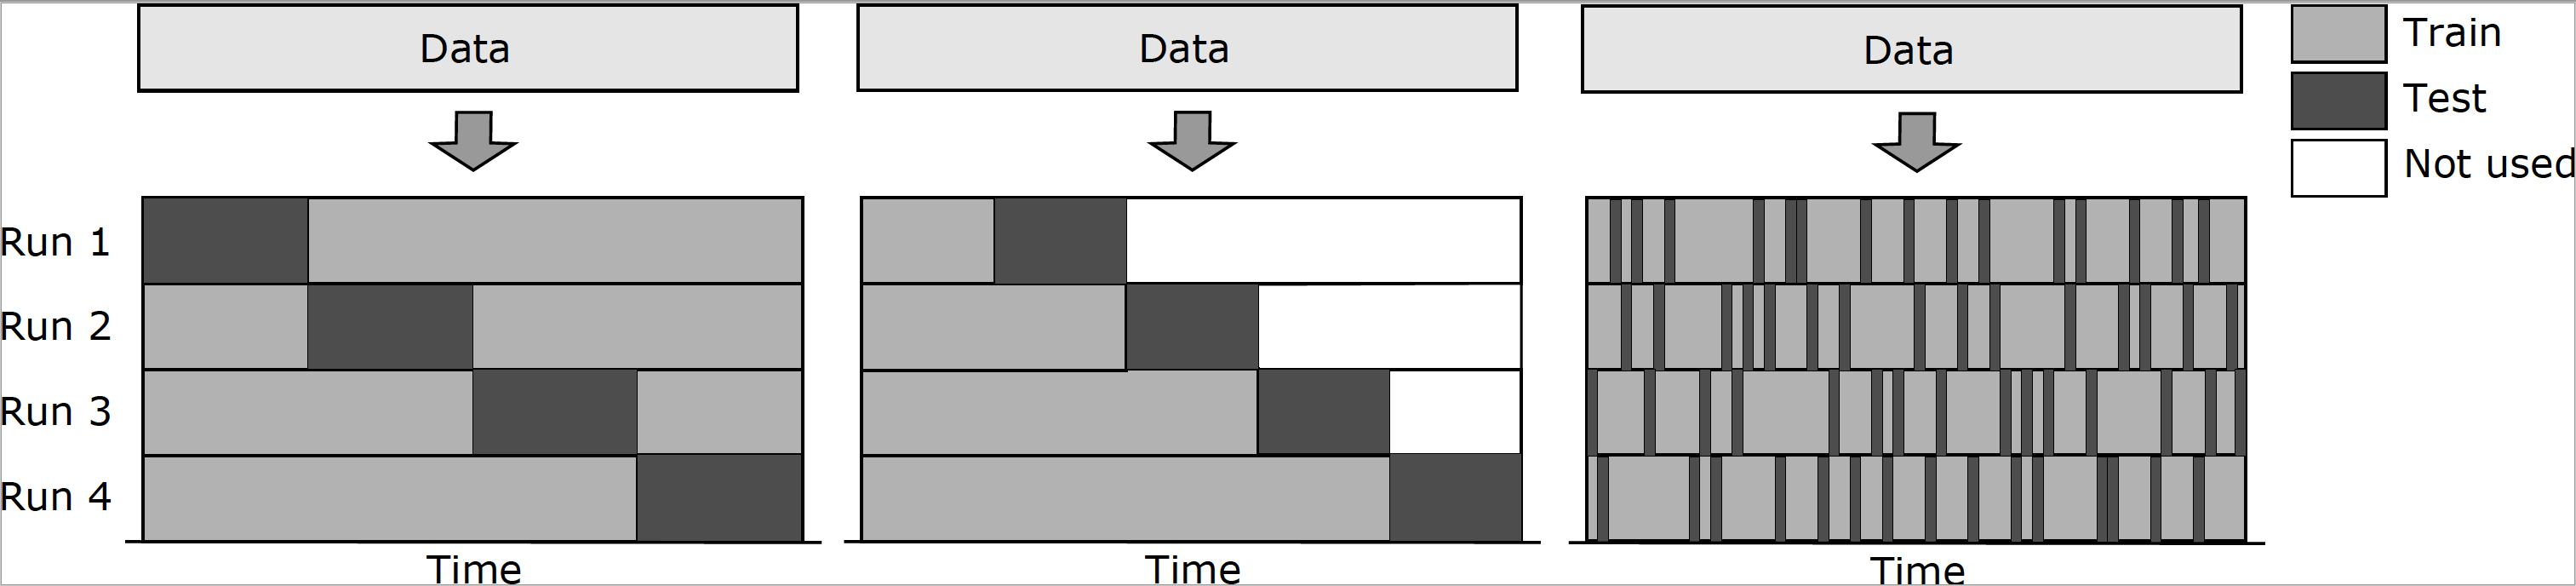 | 
|:--:| 
| *Source: Own figure.* |



In [ ]:
## This block is from last time 
data = pd.read_csv(DATA_URL, parse_dates=[0], index_col=0)
# add sine/cosine encoding for hour of day and month of the year
data["hour_x"] = np.sin(np.radians((360/24) * data.index.hour))
data["hour_y"] = np.cos(np.radians((360/24) * data.index.hour))
data["month_x"] = np.sin(np.radians((360/12) * data.index.month))
data["month_y"] = np.cos(np.radians((360/12) * data.index.month))

# temperature related variables, the mean of last day and lagged by one value, which may better capture the "recency effect"
data["temperature_rolling_mean"] = data.loc[:,"temperature"].rolling(window=24).mean()
data["temperature_lag_1"] = data.temperature.shift(1)

# Add lags up to one day
MAX_LAG = 24
for lag in range(1, MAX_LAG+1):
    data["load_lag_" + str(lag)] = data["load"].shift(lag)

# add calendar-based variables as categorical data
data["day_of_week"] = data.index.weekday
data["hour_of_day"] = data.index.hour
data["month_of_year"] = data.index.month
data["weekend"] = data.index.weekday.isin([5,6])
data = pd.get_dummies(data, columns=["day_of_week", "hour_of_day", "month_of_year"])

H = 24
Y = pd.DataFrame(index = data.index)
for h in range(H):
    Y["h_" + str(h)] = data.load.shift(-h)

scaler = StandardScaler()
numeric_cols = ['temperature'] + [c for c in data.columns if "load_lag" in c] 
categorical_cols = [c for c in data.columns if "hour_of_day" in c] + [c for c in data.columns if "day_of_week" in c] + [c for c in data.columns if "month_of_year" in c]
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)
categoricals = data[categorical_cols]

X = pd.concat([numerics, categoricals],axis=1)
X, Y = X.iloc[MAX_LAG:-H,:], Y.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)


Now let's compare the errors using the three schemes.

In [ ]:
N  = 4
knn = KNeighborsRegressor()
knn_parameters = {"n_neighbors" : [3, 6, 12, 18, 24]}

# Using shuffle=False, the KFold represents "blocked cross-validation", i.e. consequitive blocks remain together
gs_cv_block = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=False), n_jobs=-1, return_train_score=True)
gs_cv_block.fit(X_train, y_train)
print(gs_cv_block.best_params_) 
y_hat = gs_cv_block.predict(X_test)
print(f"Test MAPE Blocked: {mape(y_test, y_hat):.2f}")

# Using shuffle=True, the KFold represents regular, completely shuffled cross-validation
gs_cv_shuffle = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=True), n_jobs=-1, return_train_score=True)
gs_cv_shuffle.fit(X_train, y_train)
print(gs_cv_shuffle.best_params_) 
y_hat = gs_cv_shuffle.predict(X_test)
print(f"Test MAPE Shuffled: {mape(y_test, y_hat):.2f}")

# Sklearn also includes a CV scheme for time series
gs_cv_ts = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=TimeSeriesSplit(n_splits=N), n_jobs=-1, return_train_score=True)
gs_cv_ts.fit(X_train, y_train)
print(gs_cv_ts.best_params_) 
y_hat = gs_cv_ts.predict(X_test)
print(f"Test MAPE Time Series CV: {mape(y_test, y_hat):.2f}")

First comparing the result of the test set, they all improve on the baseline model that is not tuned and are having a similar effect. However, they result in slightly different results. How to choose your scheme?

In cross-validation schemes, an important consideration is that the folds should generally be independent and follow the distribution of the actual data. Also you want to use as much of your data as possible. We analyze this by plotting the negative MSE errors of the different folds.

In [ ]:
cv_results = pd.concat([pd.DataFrame(gs_cv_ts.cv_results_), pd.DataFrame(gs_cv_shuffle.cv_results_), pd.DataFrame(gs_cv_block.cv_results_)], keys=["ts", "shuffle", "block"]).reset_index()
fig, ax = plt.subplots(figsize=(12,4))   
sns.heatmap(cv_results.pivot(index="level_0", columns="param_n_neighbors", values=["mean_test_score", "split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score"]), ax=ax)

We see that the errors across folds are similar for shuffled and blocked CV, but some folds have much higher errors for time split.

For the time series scheme, this is due to the fact that the distribution in the folds varies a lot due to the yearly seasonality, hence violating the latter assumption of the same distribution. The shuffled scheme has a more stable distributions across the folds, compared to the other schemes. However, given the lagged, auto-correlation variables, the shuffled scheme violates the independence assumption, as data "leaks" between the folds. This may by alright, if errors are uncorrelated (see [3] if you want to deep dive this topic). A blocked scheme with some large N could be a compromise here. However, the shuffled and blocked themes are essentially using data from "the future", which may also be not alright in settings where your time series is non-stationary, as this may make your model overly confident.

## 👉 *Main Take Away Messages*
- Especially one-step ahead forecasts can give you the illusion of a good forecast, as the scale of the series plays into the evaluation. Hence, you should analyse the differenced series, as well. Also, always compare your model to a reasonable benchmark. For one-step ahead forecasting, you must be able to reliably beat the persistence forecast, otherwise you may be trying to predict a random walk.
- The cross-validation scheme you choose will be determinant to get good generalization results. An unrealistic cross-validation scheme may produce overly-optimistic results on the validation set that will in turn lead to poor results on the unseen test set. A time series specific split should most often be the starting point for time series forecasts. However, if this leads to problems with your available data, a blocked theme can be also appropriate. Read more on this [here](https://arxiv.org/pdf/2203.10716.pdf).

# Preparing the Data for Training and Testing <a name="inputoutput"></a>

Here, we follow the *direct* forecasting scheme. The target is prepared for multi-output regression models in shape (n samples, H) with H being the forecast horizon in hours. Of course, feel free to code up an iterative scheme! 

In [ ]:
H = 24
Y = pd.DataFrame(index = data.index)
for h in range(H):
    Y["h_" + str(h)] = data.load.shift(-h)

Numeric input should be scaled using for instance standardization or min/max scaling. Categorical data should be one-hot encoded (already done above).

In [ ]:
scaler = StandardScaler()
numeric_cols = ['temperature'] + [c for c in data.columns if "load_lag" in c] 
categorical_cols = [c for c in data.columns if "hour_of_day" in c] + [c for c in data.columns if "day_of_week" in c] + [c for c in data.columns if "month_of_year" in c]
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)
categoricals = data[categorical_cols]

X = pd.concat([numerics, categoricals],axis=1)

Note, that generally there are different ways that one can use to preprocess data. Here we use standard scaling, but you may also try Min-/Max-Scaling, Logarithmic Transforms or Box-Cox-Transforms, depending on the models used. See <a href="https://www.springeropen.com/">Section 6.1.3</a>.


The available data is split up to train and test data. Here, we use a blocked cross-validation scheme (see Section [Cross-validation for time series](#crossvalidation) for some other possible schemes)

In [ ]:
X, Y = X.iloc[MAX_LAG:-H,:], Y.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

# Model Fitting <a name="modelfit"></a>

This section considers fitting the models to the training data. More details on training data can be found in <a href="https://www.springeropen.com/">Chapter 8</a>.
 

## Benchmark/Baseline Models <a name="benchmark"></a>
For time series models it can make sense to start with simple benchmarks. For one-step ahead forecasting this may be the *persistence model*, i.e., predicting the same value as in the previous time step. For seasonal data this may also be the value of the last season, e.g., last Monday for a Monday or the value from last year. Or moving averages of the previous timesteps (or previous several seasons). For some seasonal data such *naive models* can be surprisingly hard to beat. Some standard benchmark models can be found in <a href="https://www.springeropen.com/">Chapter 9</a>.

Given the weekly seasonality and task of predicting 24 hours ahead, using last week's load at the same time could be a reasonable benchmark. This model is sometimes referred to as *seasonal persistence* model:

In [ ]:
y_hat_naive = Y.shift(168).loc[X_test.index]

y_hat_sma = np.divide(Y.shift(168).loc[X_test.index] + Y.shift(168*2).loc[X_test.index] + Y.shift(168*3).loc[X_test.index] + Y.shift(168*4).loc[X_test.index], 4)

Let's use the mean absolute percentage error as a metric:

In [ ]:
def mape(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred) * 100

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [ ]:
print(f"MAPE Naive: {mape(y_test, y_hat_naive):.2f}, SMA: {mape(y_test, y_hat_sma):.2f}")
print(f"RMSE Naive: {rmse(y_test, y_hat_naive):.2f}, SMA: {rmse(y_test, y_hat_sma):.2f}")

Now let's fit some sklearn machine learning models to the data and compare them in term of MAPE. 

Our simplest model is the k nearest neighbors. 



In [ ]:
# Fit a KNN regression model
model = KNeighborsRegressor()
model.fit(X_train, y_train)

y_hat_knn = pd.DataFrame(model.predict(X_test), index=y_test.index)

print(f"MAPE SMA: {mape(y_test, y_hat_sma):.2f}, KNN: {mape(y_test, y_hat_knn):.2f}")

Great it beat the simple benchmark!

Let's now try another simple model, a L2-penalized linear regression model.
 
KNN is already capable of multi-output regression to predict several time steps ahead. The linear model needs to be wrapped in the MultiOutputRegressor model, which fits one model per output variable.

In [ ]:
model = MultiOutputRegressor(Ridge())
model.fit(X_train, y_train)

y_hat_linear = pd.DataFrame(model.predict(X_test), index=y_test.index)

print(f"KNN: {mape(y_test, y_hat_knn):.2f}, Ridge Regression: {mape(y_test, y_hat_linear):.2f}")

Our second model does not provide a significant improvement in terms of MAPE. 😏 

One can also compare the forecast to the actual visually by plotting one complete week. We see that the ridge model captures well the patterns but tends to underestimate peak demand.

In [ ]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test[y_test.index.hour==0].iloc[:7].values.reshape(-1,1),label='ground truth')
ax.plot(y_hat_linear[y_hat_linear.index.hour==0].iloc[:7].values.reshape(-1,1),label='linear regression')
ax.plot(y_hat_knn[y_hat_knn.index.hour==0].iloc[:7].values.reshape(-1,1),label='knn')
ax.plot(y_hat_naive[y_hat_naive.index.hour==0].iloc[:7].values.reshape(-1,1),label='naive')
ax.plot(y_hat_sma[y_hat_sma.index.hour==0].iloc[:7].values.reshape(-1,1),label='sma')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('hours')
plt.legend()

## Comparing Encodings for categorical variables <a name="encodings"></a>

As discussed above, calendar-based categorical variables can be encoded using one-hot encoding or using sine/cosine. The latter has the advantage of using fewer variables and incorporating knowledge about the distance of, for instance, the hours of the day at night (11pm is close to 1 am) or months (January is close to December). 

In [ ]:
scaler = StandardScaler()
numeric_cols = ["temperature","hour_x", "hour_y", "month_x", "month_y"] + [c for c in data.columns if "load_lag" in c] 
numerics = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), index=data.index, columns=numeric_cols)

X_sine = numerics
X_sine = X_sine.iloc[MAX_LAG:-H,:]
X_sine_train, X_sine_test, _, _ = train_test_split(X_sine, Y, test_size=0.25, shuffle=False)

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
print(f"MAPE One-hot encoding: {mape(y_test, y_hat):.2f}")

knn = KNeighborsRegressor()
knn.fit(X_sine_train, y_train)
y_hat = knn.predict(X_sine_test)
print(f"MAPE Sine/Cose Encoding: {mape(y_test, y_hat):.2f}")

Here, we find that one hot encoding works better than the sine/cosine encoding.

## Fitting a neural network using Tensorflow <a name="ann"></a>

Finally, we use a simple artificial neural network using Tensorflow. There are different ways to use Tensorflow, e.g. using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) or the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). Here, we use the [sklearn integration](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor). 

This allows easy comparison to "simpler" models that use the sklearn interface, like the sklearn models or [XGBoost](https://xgboost.readthedocs.io/en/latest/) or [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

More information on all these models can be found in <a href="https://www.springeropen.com/">Chapter 10</a>.

In [ ]:
def create_my_ann(input_dim, output_dim, hidden_neurons):
    model = Sequential()
    model.add(Dense(hidden_neurons, input_dim=input_dim, activation='relu'))
    model.add(Dense(hidden_neurons, input_dim=hidden_neurons, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(output_dim))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = KerasRegressor(build_fn=create_my_ann, input_dim=X_test.shape[1], output_dim=H, hidden_neurons=90, nb_epoch=1000, batch_size=16, verbose=True)
model.fit(X_train.values, y_train.values)

y_hat_ann = pd.DataFrame(model.predict(X_test), index=y_test.index)
print(f"MAPE: {mape(y_test, y_hat_ann):.2f}")

fig, ax = plt.subplots()
ax.plot(y_test[y_test.index.hour==0].iloc[:7].values.reshape(-1,1),label='ground truth')
ax.plot(y_hat_ann[y_hat_ann.index.hour==0].iloc[:7].values.reshape(-1,1),label='ann')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('hours')
plt.legend()

This model turns out to perform worse than our initial baseline. Some additional tuning is needed to improve the results!

Here some ideas to try to improve the model:
- try different regularisation methods to avoid possible overfitting, 
- try to train the model on more data for your specific problem (use it as a _global model_),
- try to add more features (longer time window?).

# Model diagnostics <a name="diagnostics"></a>

A good forecasting method will yield residuals with the following properties (See <a href="https://www.springeropen.com/">Section 7.5</a>.):
* *The residuals are uncorrelated.* If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
* *The residuals have zero mean.* If the residuals have a mean other than zero, then the forecasts are biased.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties:
* The residuals have constant variance.
* The residuals are normally distributed.

The following plots show exemplarily diagnostic plots of a historgram of residuals (top) and the autocorrelation plot of the residuals (bottom).

| | 
|:--:|
| <img src="https://otexts.com/fpp3/fpp_files/figure-html/GSPhist-1.png" alt="histogram" style="float: left; margin-right: 10px;" /> | 
| <img src="https://otexts.com/fpp3/fpp_files/figure-html/GSPacf-1.png"   alt="residuals AR" style="float: left; margin-right: 10px;" /> | 
| *Source: [FPP book](https://otexts.com/fpp3/).* |



In [ ]:
step_ahead_errors = y_hat_knn.iloc[:,0]-y_test.iloc[:,0]

In [ ]:
plt.hist(step_ahead_errors, bins=30);
print(f"Mean: {step_ahead_errors.mean():.2f}")

In [ ]:
acf = plot_acf(step_ahead_errors, lags=8*24)

The diagnostics show that there is still room for improving the model, as the distribution of errors shows that the model is biased and the autocorrelation shows that there is still information not properly included in the model!

## 👉 *Main Take Away Messages*
- *Start by establishing some simple, but also stronger benchmarks (simple seasonal models and some statistical or simple ML models) before going to more complex models like LSTM, CNN or transformers.*
- *Don't just look at the RMSE, but also use plots of the forecasts and diagnostics plots of the errors to see where your model still fails. Then try different features or feature encodings to improve your model.* 



# Where to go from here? 🧭  <a name="sota"></a>

Some ideas on where to contribute in the area of ML and load forecasting:
- *Better Bechmarking Frameworks*: Currently, there are a lot of papers that don't compare their models to each other, as a standardized benchmark (framework) is missing. A huge benefit to the load forecasting community would be reference implementations and standardised datasets (contact me if you are interested in contributing :)),
- *State-of-the-art deep models*: Can temporal variants of transformers outperform temporal convolutional models?
- *Probabilistic models*: As you see, especially for only few households forecast errors are high. Here, probabilistic forecasts (intervals, densities, scenarios) can inform more than point forecasts. The marginal distributions are typically complex (multi-model, skewed), hence data-drive approaches can be interesting here! See <a href="https://www.springeropen.com/">Chapter 11</a> for more details on probabilistic forecasts.
- *Hierarchical and graphical models*: The electric power system is hierarchial and household locations are spatial information that could be utilised. Consider hierarchical and graphical models for load forecasting!
- *Multivariate models*: Often for buildings there are several relevant time series, e.g. the thermal and electric load as well as load from EV. Given that all of those are depending on similar features (weather, occupancy, ...) once could consider forecasting all domains at once!
- *Online forecasting*: As discussed in the introduction, forecasting is relevant at different spatial dimensions. Some forecasts may be done completely distributed "in the edge". Here, methods that are training "online" withouth access to large storage, could be an interesting direction.

# References 📚

- **[1]** *Haben, S., Arora, S., Giasemidis, G., Voss, M., & Greetham, D. V. (2021). Review of low voltage load forecasting: Methods, applications, and recommendations. Applied Energy, 304, 117798.* [Applied Energy Version](https://www.sciencedirect.com/science/article/abs/pii/S0306261921011326). [Preprint Version](https://arxiv.org/pdf/2106.00006.pdf).
- **[2]** *Rolnick, D., Donti, P. L., Kaack, L. H., Kochanski, K., Lacoste, A., Sankaran, K., ... & Bengio, Y. (2022). Tackling climate change with machine learning. ACM Computing Surveys (CSUR), 55(2), 1-96.* [Link](https://dl.acm.org/doi/full/10.1145/3485128).
- **[3]** *Hewamalage, Hansika, Klaus Ackermann, and Christoph Bergmeir. Forecast Evaluation for Data Scientists: Common Pitfalls and Best Practices. arXiv preprint arXiv:2203.10716 (2022).* [Link](https://arxiv.org/pdf/2203.10716.pdf).


# Selected Ressources on Time Series 🎒

## Tools and Libraries 

### **Tools in Python** 🐍

- [sktime](https://www.sktime.org/en/stable/) and [tslearn](https://github.com/tslearn-team/tslearn/tree/main/tslearn) are two similar packages that allow to apply sklearn models to time series problems. Both are capable of supporting forecasting, but also clustering and classification tasks. tslearn ist stronger in time series clustering and has implemented many popular time series distance measures such as [Dynamic Time Warping](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw.html#tslearn.metrics.dtw) or the [Matrix Profile](https://tslearn.readthedocs.io/en/stable/user_guide/matrix-profile.html#matrix-profile) that can be useful in comparing time series and finding (recurring) pattern.
- [statsmodels](https://www.statsmodels.org/devel/api.html#statsmodels-tsa-api) Statsmodels is a general stats library, but it contains different time series specific statistical tests and models.
- [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html) is a fantastic python package that can automatically calculate a large number of time series features. This can be used for forecasting tasks, but also for classification or clustering of time series.
- [Facebook Prophet](https://facebook.github.io/prophet/): A comprehensive industry-focused suite of a group of forecasting models that automates much of the modeling process.
- [Darts](https://unit8co.github.io/darts/#forecasting-models): Another comprehensive industry-focused suite. It contains strong statistical models like ARIMA or THETA, wrappers for sklearn, strong ML models like Gradient Boosting and deep learning models like LSTM/GRU, NBEATS, TCN and Transformers. It includes also Prophet. Compared to Prophet, this gives you more choices from simple to sophisticated and includes state-of-the-art models from deep learning.
- Visualization: Your favorite Python library will likely also have some ways to plot time series. For simple in the easiest case you can start with a line chart ([Matplotlib](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.plot.html) or [Seaborn](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot)). Others make you handle time series more explicitly like [Plotly](https://plotly.com/python/time-series/). However, besides line plots, you may also consider heat maps, histograms, box plots, scatter plots, and the more specialized plots such as autocorrelation plots are built into [pandas](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html) or [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.acorr.html). Of course there is a plethora of other specialized sometimes useful plots, e.g. [clock plots](https://github.com/esc-data-science/clock_plot).

### **Tools in R**

- [List of packages by Prof. Hyndamn](https://robjhyndman.com/software/) Prof. Hyndman has co-authored many relevant packages in the R space. From the older very popular [forecast package](https://pkg.robjhyndman.com/forecast/) to "tidyverse" packages [fable](https://github.com/tidyverts/fable) and [feasts](https://github.com/tidyverts/feasts).
- [Facebook Prophet](https://facebook.github.io/prophet/): Prophet (see above) is also available in R.

## Load Datasets 

If you are looking for time series data for your analysis, check out the following sources:

- [Low-voltage Load Data](https://low-voltage-loadforecasting.github.io/) A curated list of datasets from house-hold level to feeder level. You know one that is missing? Let me know or raise [an issue](https://github.com/low-voltage-loadforecasting/low-voltage-loadforecasting.github.io/issues)!
- [Monash Time Series Forecasting Repository](https://forecastingdata.org/). This aims to be a standard repository for reproducible research on time series and has some load data. 
- [CCAI Wiki](https://wiki.climatechange.ai/wiki/Energy_Demand_Forecasting).Some initial ressources on load forecasting can be found in the CCAI Wiki.